In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
# Neural network for Forecasting data
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.005,    #0.05               best with 0.001
  decay_steps=100, #100        best with 100
  decay_rate=1, #1              best with 1
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=100, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[
                  tf.keras.losses.MeanAbsoluteError("auto", "mean_absolute_error"),
                  'accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            verbose=2)

    return history

In [3]:
#Training data set

input_train=np.load('../data/Burgers/input_train.npy')
input_test=np.load('../data/Burgers/input_test.npy')
output_train=np.load('../data/Burgers/output_train.npy')
output_test=np.load('../data/Burgers/output_test.npy')

INPUTDIM = (input_train.shape[1],)
OUTPUTDIM = (output_train.shape[1],)

In [4]:
# def Fourier_layer(input_layer):
#     fft =  layers.Lambda(fft_function) (input_layer)

#     w = layers.Dense(fft.get_shape().as_list()[1], kernel_regularizer = regularizers.l2(0.0)) (fft)

#     ifft = layers.Lambda(ifft_function) (tf.dtypes.complex(w,tf.multiply(w,tf.zeros_like(w))))

#     bias = layers.Dense(ifft.get_shape().as_list()[1], kernel_regularizer = regularizers.l2(0.0)) (input_layer)

#     print(ifft.shape)
#     print(bias.shape)

#     return layers.Add() ([ifft, bias])

In [5]:
class FFT_Layer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(FFT_Layer, self).__init__(**kwargs)
        self._fft_shape = None
        self._ifft_shape = None

    def call(self, inputs):
        fft =  layers.Lambda(self.fft_function) (inputs)
        if self.fft_shape == None:
            self.fft_shape = fft.get_shape().as_list()[1]
        w = layers.Dense(self.fft_shape, kernel_regularizer = regularizers.l2(0.0)) (w)
        ifft = layers.Lambda(self.ifft_function) (tf.dtypes.complex(w,tf.multiply(w,tf.zeros_like(w))))
        if self.ifft_shape == None:
            self.ifft_shape = ifft.get_shape().as_list()[1]
        return ifft
    
    def fft_function(tensor):
        return tf.signal.rfft(tensor)

    def ifft_function(tensor):
        return tf.signal.irfft(tensor)
    
    @property
    def fft_shape(self):
        return self._fft_shape
    
    @property
    def ifft_shape(self):
        return self._ifft_shape
    
    @fft_shape.setter
    def fft_shape(self, value):
        self._fft_shape = value

    @ifft_shape.setter
    def ifft_shape(self, value):
        self._ifft_shape = value

    
class Bias_Layer(tf.keras.layers.Layer):
    class CustomError(Exception):
        def __init__(self, message):
            super().__init__(message)

    def __init__(self, **kwargs):
        super(Bias_Layer, self).__init__(**kwargs)
        print(FFT_Layer.ifft_shape)
        if FFT_Layer.ifft_shape == None:
            raise CustomError("Bias layer ha been constructed before the FFT layer")
        self.bias = layers.Dense(FFT_Layer.ifft_shape, kernel_regularizer = regularizers.l2(0.0))
        
    def call(self, inputs):
        return self.bias(inputs)
    
class Fourier_Layer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(Fourier_Layer, self).__init__(**kwargs)
        self.fft_layer = FFT_Layer()
        self.bias_layer = Bias_Layer()

    def call(self, inputs):
        fft_layer = self.fft_layer(inputs)
        bias_layer = self.bias_layer(inputs)
        added_layers = layers.Add() ([fft_layer, bias_layer])
        return layers.Activation('tanh') (added_layers)
    

n=1

input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

P_layer = layers.Dense(64, activation='tanh', kernel_regularizer = regularizers.l2(0.0), name='P_layer') (input_layer)

# Initialize an empty list to store the custom module outputs
outputs = []

# Repeat the custom module 'n' times
for i in range(n):
    fourier_module_output = Fourier_Layer()(P_layer)
    outputs.append(fourier_module_output)

# Concatenate the outputs of the custom modules
concatenated_output = tf.keras.layers.Concatenate()(outputs)

output_layer = layers.Dense(OUTPUTDIM[0], activation='tanh', kernel_regularizer = regularizers.l2(0.0), name='output_layer') (concatenated_output)

model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name ='FNO')

model.summary()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'property'

In [36]:
FFT_Layer.fft_shape

<function property.getter>

In [46]:
history = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, optimizer=None, max_epochs=100)

Model: "FNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 fft_transform_layer (Lambda)   (None, 51)           0           ['input_layer[0][0]']            
                                                                                                  
 fft_dense_layer (Dense)        (None, 51)           2652        ['fft_transform_layer[0][0]']    
                                                                                                  
 tf.zeros_like_5 (TFOpLambda)   (None, 51)           0           ['fft_dense_layer[0][0]']        
                                                                                                

Epoch 1/100
704/704 - 7s - loss: 1.0607 - mean_absolute_error: 0.3827 - accuracy: 0.4351 - val_loss: 1.3533 - val_mean_absolute_error: 0.5127 - val_accuracy: 0.4444 - 7s/epoch - 9ms/step
Epoch 2/100
704/704 - 5s - loss: 0.7771 - mean_absolute_error: 0.3754 - accuracy: 0.4518 - val_loss: 1.3540 - val_mean_absolute_error: 0.5165 - val_accuracy: 0.4444 - 5s/epoch - 6ms/step
Epoch 3/100
704/704 - 4s - loss: 0.7769 - mean_absolute_error: 0.3776 - accuracy: 0.4598 - val_loss: 1.3530 - val_mean_absolute_error: 0.5115 - val_accuracy: 0.5185 - 4s/epoch - 6ms/step
Epoch 4/100
704/704 - 5s - loss: 0.7769 - mean_absolute_error: 0.3756 - accuracy: 0.4620 - val_loss: 1.3539 - val_mean_absolute_error: 0.5157 - val_accuracy: 0.4938 - 5s/epoch - 7ms/step
Epoch 5/100
704/704 - 6s - loss: 0.7769 - mean_absolute_error: 0.3759 - accuracy: 0.4673 - val_loss: 1.3534 - val_mean_absolute_error: 0.5105 - val_accuracy: 0.5185 - 6s/epoch - 9ms/step
Epoch 6/100
704/704 - 11s - loss: 0.7769 - mean_absolute_error: 0

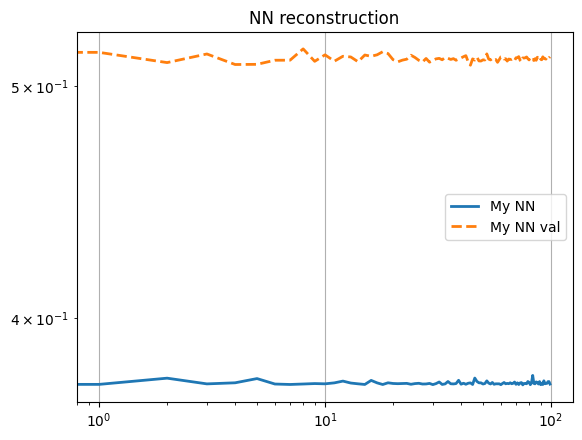

In [47]:
bc     = history.history['mean_absolute_error']
val_bc = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN reconstruction')
plt.grid(True)
#plt.show(block=False)

plt.legend(('My NN','My NN val'))
plt.show()

In [48]:
rec_output = model.predict(input_train)

704/704 [==============================] - 4s 6ms/step


Text(0.5, 0, 'x [-]')

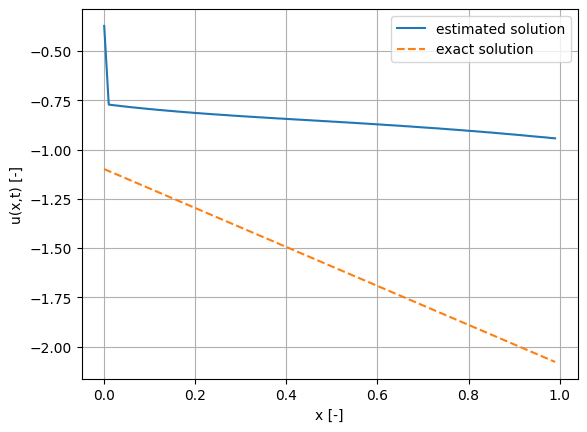

In [49]:
index = 126
dx = 0.01
xx=np.arange(0,1,dx)

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')


In [50]:
save_NN = False
# save_NN = True
if save_NN:
    model.save('../data/Burgers/model_NN.h5')
    print('NN saved')